In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from PIL import Image

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn import neighbors
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import tree
from sklearn import ensemble
from sklearn import svm

from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

import cv2
#from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

from time import time

# Algorithms

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score, f1_score, plot_confusion_matrix
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

def create_vectorizer(train_data, *kwargs, max_features=1):
    vectorizer = CountVectorizer(max_features=max_features)
    res        = [vectorizer]
    res.append(vectorizer.fit_transform(train_data).toarray())
    for arg in kwargs:
        res.append(vectorizer.transform(arg).toarray())
    return res

scaler = None
def create_scaling(X):
    global scaler
    scaler = StandardScaler().fit(X)

def remove_outlyers(data, label, threshold=100):
    mask = (data>threshold).sum(axis=1)==0
    print("removing {} rows\n".format(np.sum(~mask)))
    return [data[mask], label.drop(label.index[~mask])]

def create_knn(train_data, target, **kwargs):
    clf = KNeighborsClassifier(**kwargs)
    clf.fit(train_data, target )
    return clf

def create_perceptron(train_data, target, grid=[], **kwargs):
    if grid != []:
        clf = GridSearchCV(Perceptron(), grid, refit = True, verbose = 3,n_jobs=2)
    else:
        clf = Perceptron(**kwargs)
    clf.fit(train_data, target)
    return clf

def create_rnd_forrest(train_data, target, grid=[], **kwargs):
    if grid != []:
        clf = GridSearchCV(RandomForestClassifier(), grid, refit = True, verbose = 3,n_jobs=2)
    else:
        clf = RandomForestClassifier(**kwargs)
    clf.fit(train_data, target)
    return clf

def create_nb(train_data, target, **kwargs):
    clf =MultinomialNB( **kwargs)
    clf.fit(train_data , target)
    return clf
    
def _create_MLP(input_dim):
    model = Sequential()
    model.add(Dense(256, activation="relu", input_shape=(input_dim,)))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

def create_MLP(X_train, y_train):
    
    mlp = KerasClassifier(build_fn=(lambda: _create_MLP(X_train.shape[1])), epochs=15, batch_size=32, verbose=0)
    mlp.fit(X_train, np_utils.to_categorical(y_train))
    return mlp

def plot_confusion_matrix_MLP(mlp, X_test, y_test):
    y_pred = mlp.predict(X_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='pred'))
    disp.plot()
    plt.title('Multi-layer perceptron confusion matrix')
    plt.show()
    
def get_metrics(algo, test_data, test_target, train_data, train_target):
    pred_test  = algo.predict(test_data)
    pred_train = algo.predict(train_data)

    return classification_report(test_target, pred_test,output_dict=True),\
           classification_report(train_target, pred_train,output_dict=True)



In [3]:
times = {}
times_prepro = {}
times_test = {}

# Import Cifar using Tensor flow

In [4]:
from tensorflow.keras.datasets import cifar10
(X_train,y_train) , (X_test,y_test) = cifar10.load_data()
X_train = X_train
y_train = y_train
X_test = X_test
y_test = y_test
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
print(X_train[0])
print(X_test[0])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
[[[158 112  49]
  [159 111  47]
  [165 116  51]
  ...
  [137  95  36]
  [126  91  36]
  [116  85  33]]

 [[152 112  51]
  [151 110  40]
  [159 114  45]
  ...
  [136  95  31]
  [125  91  32]
  [119  88  34]]

 [[151 110  47]
  [151 109  33]
  [158 111  36]
  ...
  [139  98  34]
  [130  95  34]
  [120  89  33]]

 ...

 [[ 68 124 177]
  [ 42 100 148]
  [ 31  88 137]
  ..

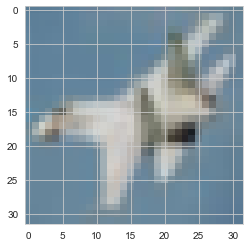

In [6]:
#Example of image
plt.imshow(X_train[10])
plt.imshow(X_test[10])

(256, 1)


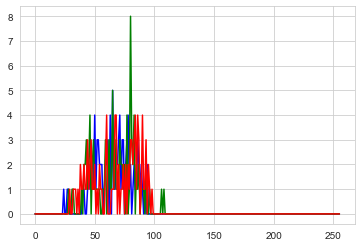

In [7]:
#Example of RGB histogram plot
images=X_train[10]
channels = [0] # [1] or [2] for green or red 0 is blue
mask= None
histSize = [256] # Number of bins, forr full scale take 256
ranges= [0,256] # this is our RANGE. Normally, it is [0,256].
hist_blue=cv2.calcHist(images, channels, mask, histSize, ranges)
hist_green=cv2.calcHist(images, [1], mask, histSize, ranges)
hist_red=cv2.calcHist(images, [2], mask, histSize, ranges)
#plt.plot(hist_blue, hist_green, hist_red)
plt.plot(hist_blue, color= 'blue')
plt.plot(hist_green, color= 'green')
plt.plot(hist_red , color ='red')
print(hist_green.shape)

In [8]:
print(class_names[y_train[10][0]])

deer


In [9]:
mask= None
histSize = [256] # Number of bins, forr full scale take 256
ranges= [0,256] # this is our RANGE. Normally, it is [0,256].

times_prepro['histogram'] = time()
data=[]
for i in range(0,len(X_train)):
    hist=np.empty((0,0))
    images = X_train[i]
    #imagePIL = imagePIL.convert('RGB')   
    #images = imagePIL.convert('RGB') 
    hist_blue=cv2.calcHist(images, [0], mask, histSize, ranges)
    hist_green=cv2.calcHist(images, [1], mask, histSize, ranges)
    hist_red=cv2.calcHist(images, [2], mask, histSize, ranges)
    hist = np.append(hist, hist_blue)
    hist = np.append(hist, hist_green)
    hist = np.append(hist, hist_red)
    featureVector=hist
    #if (len(featureVector) != 768): # just a sanity check; with the transformation to RGB, this should never happen
    #    print("Unexpected length of feature vector: " + i)
    data.append((featureVector))
np_data=np.array(data)
print(np_data.shape)
times_prepro['histogram'] = time() - times_prepro['histogram']

# We have to convert the test set as well

times_test['histogram'] = time()
data=[]
for i in range(0,len(X_test)):
    hist=np.empty((0,0))
    images = X_test[i]
    #imagePIL = imagePIL.convert('RGB')   
    #images = imagePIL.convert('RGB') 
    hist_blue=cv2.calcHist(images, [0], mask, histSize, ranges)
    hist_green=cv2.calcHist(images, [1], mask, histSize, ranges)
    hist_red=cv2.calcHist(images, [2], mask, histSize, ranges)
    hist = np.append(hist, hist_blue)
    hist = np.append(hist, hist_green)
    hist = np.append(hist, hist_red)
    featureVector=hist
    #if (len(featureVector) != 768): # just a sanity check; with the transformation to RGB, this should never happen
    #    print("Unexpected length of feature vector: " + i)
    data.append((featureVector))
np_data_test=np.array(data)
print(np_data_test.shape)
times_test['histogram'] = time() - times_test['histogram']

(50000, 768)
(10000, 768)


In [10]:
print(len(X_train))

50000


In [11]:
dataOpenCV_1D=[]
dataOpenCV_2D=[]
dataOpenCV_3D=[]

dataOpenCV_1D_test=[]
dataOpenCV_2D_test=[]
dataOpenCV_3D_test=[]

times_prepro['histogram 1D'] = time()

# use our own simple function to flatten the 2D arrays
flatten = lambda l: [item for sublist in l for item in sublist]

for i in range(0,len(X_train)):
    featuresOpenCV_1D = []
    #hist=np.empty((0,0))
    images = X_train[i]
    
    channels= ([0], [1], [2])
    color = ("b", "g", "r")
    
    histSize_1d=[64] 
    featuresOpenCV_1D = []
    for (channels, color) in zip(channels,color):
        
        # Not all images in our dataset are in RGB color scheme (e.g. indexed colours)
        # We need to make sure that they are RGB , otherwise we can't expect to have exactly three RGB channels..
        #imagePIL = imagePIL.convert('RGB')   
        #images = imagePIL.convert('RGB') 
        hist_opencv=cv2.calcHist(images, channels, mask, histSize_1d, ranges)
        featuresOpenCV_1D=np.append(featuresOpenCV_1D, hist_opencv)
    featureVectorOpenCV_1D = featuresOpenCV_1D
    dataOpenCV_1D.append(featureVectorOpenCV_1D) 
    
    #if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
    #    print "Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + i
    
np_dataOpenCV_1D=np.array(dataOpenCV_1D)
times_prepro['histogram 1D'] = time() - times_prepro['histogram 1D']


times_test['histogram 1D'] = time()

for i in range(0,len(X_test)):

    #hist=np.empty((0,0))
    images = X_test[i]
    
    channels= ([0], [1], [2])
    color = ("b", "g", "r")
    
    histSize_1d=[64] 
    featuresOpenCV_1D = []
    for (channels, color) in zip(channels,color):
        #imagePIL = imagePIL.convert('RGB')   
        #images = imagePIL.convert('RGB') 
        hist_opencv=cv2.calcHist(images, channels, mask, histSize_1d, ranges)
        featuresOpenCV_1D=np.append(featuresOpenCV_1D, hist_opencv)
    featureVectorOpenCV_1D = featuresOpenCV_1D
    dataOpenCV_1D_test.append(featureVectorOpenCV_1D) 
    
    #if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
    #    print "Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + i
    
np_dataOpenCV_1D_test=np.array(dataOpenCV_1D_test)
times_test['histogram 1D'] = time() - times_test['histogram 1D']

#print(data)
print(np_dataOpenCV_1D.shape)
print(np_dataOpenCV_1D)
print(np_dataOpenCV_1D_test.shape)

(50000, 192)
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  4.  0.  0.]
 [ 0.  0.  0. ...  0.  1. 80.]
 ...
 [ 0.  0.  0. ...  9.  6.  3.]
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  4.  0.  0.]]
(10000, 192)


In [12]:
dataOpenCV_2D=[]
dataOpenCV_2D_test=[]

times_prepro['histogram 2D'] = time()

for i in range(0,len(X_train)):
    featuresOpenCV_2D = []
    #hist=np.empty((0,0))
    images = X_train[i]
    
    channels= [[0], [1], [2]]
    color = ("b", "g", "r")
    
    histSize_2d= 16 
    featuresOpenCV_2D = []
        
        # Not all images in our dataset are in RGB color scheme (e.g. indexed colours)
        # We need to make sure that they are RGB , otherwise we can't expect to have exactly three RGB channels..
        #imagePIL = imagePIL.convert('RGB')   
        #images = imagePIL.convert('RGB') 
    hist_opencv_2d_1 = cv2.calcHist(images,  [0,1], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
    hist_opencv_2d_2 = cv2.calcHist(images,  [0,2], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
    hist_opencv_2d_3 = cv2.calcHist(images,  [1,2], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
    featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_1)
    featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_2)
    featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_3)
    featureVectorOpenCV_2D = featuresOpenCV_2D # and append this to our feature vector
    dataOpenCV_2D.append(featureVectorOpenCV_2D) # now we append the feature vector to the dataset so far
    
    #if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
    #    print "Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + i
    
np_dataOpenCV_2D= np.array(dataOpenCV_2D)
times_prepro['histogram 2D'] = time() - times_prepro['histogram 2D']

# We have to extract features for the test set as well

times_test['histogram 2D'] = time()

for i in range(0,len(X_test)):
    featuresOpenCV_2D = []
    #hist=np.empty((0,0))
    images = X_test[i]
    
    channels= [[0], [1], [2]]
    color = ("b", "g", "r")
    
    histSize_2d= 16 
    featuresOpenCV_2D = []
        
        # Not all images in our dataset are in RGB color scheme (e.g. indexed colours)
        # We need to make sure that they are RGB , otherwise we can't expect to have exactly three RGB channels..
        #imagePIL = imagePIL.convert('RGB')   
        #images = imagePIL.convert('RGB') 
    hist_opencv_2d_1 = cv2.calcHist(images,  [0,1], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
    hist_opencv_2d_2 = cv2.calcHist(images,  [0,2], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
    hist_opencv_2d_3 = cv2.calcHist(images,  [1,2], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
    featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_1)
    featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_2)
    featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_3)
    featureVectorOpenCV_2D = featuresOpenCV_2D # and append this to our feature vector
    dataOpenCV_2D_test.append(featureVectorOpenCV_2D) # now we append the feature vector to the dataset so far
    
    #if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
    #    print "Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + i
    
np_dataOpenCV_2D_test= np.array(dataOpenCV_2D_test)
times_test['histogram 2D'] = time() - times_test['histogram 2D']

#print(data)
print(np_dataOpenCV_2D.shape)
print(np_dataOpenCV_2D_test.shape)
print(np_dataOpenCV_2D)

(50000, 768)
(10000, 768)
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  2.  5.]
 [ 0.  0.  0. ...  0.  1. 81.]
 ...
 [ 0.  0.  0. ...  0.  9. 18.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0. 11.  7.]]


In [13]:
dataOpenCV_3D=[]
dataOpenCV_3D_test=[]

times_prepro['histogram 3D'] = time()

for i in range(0,len(X_train)):
    featuresOpenCV_2D = []
    #hist=np.empty((0,0))
    images = X_train[i]
    
    channels= [[0], [1], [2]]
    color = ("b", "g", "r")
    
    histSize_3d= 8 
    featuresOpenCV_3D = []

    #imagePIL = imagePIL.convert('RGB')   
    #images = imagePIL.convert('RGB') 
    hist_opencv_3d = cv2.calcHist(images,  [0,1,2], mask, [histSize_3d, histSize_3d,histSize_3d ], [0, 256, 0, 256,  0, 256])
    featuresOpenCV_3D= np.append(featuresOpenCV_2D, hist_opencv_3d)
    featureVectorOpenCV_3D = featuresOpenCV_3D # and append this to our feature vector
    dataOpenCV_3D.append(featureVectorOpenCV_3D) # now we append the feature vector to the dataset so far
 
np_dataOpenCV_3D = np.array(dataOpenCV_3D)
times_prepro['histogram 3D'] = time() - times_prepro['histogram 3D']

# and for the test set

times_test['histogram 3D'] = time()

for i in range(0,len(X_test)):
    featuresOpenCV_2D = []
    #hist=np.empty((0,0))
    images = X_test[i]
    
    channels= [[0], [1], [2]]
    color = ("b", "g", "r")
    
    histSize_3d= 8 
    featuresOpenCV_3D = []

    #imagePIL = imagePIL.convert('RGB')   
    #images = imagePIL.convert('RGB') 
    hist_opencv_3d = cv2.calcHist(images,  [0,1,2], mask, [histSize_3d, histSize_3d,histSize_3d ], [0, 256, 0, 256,  0, 256])
    featuresOpenCV_3D= np.append(featuresOpenCV_2D, hist_opencv_3d)
    featureVectorOpenCV_3D = featuresOpenCV_3D # and append this to our feature vector
    dataOpenCV_3D_test.append(featureVectorOpenCV_3D) # now we append the feature vector to the dataset so far

np_dataOpenCV_3D_test= np.array(dataOpenCV_3D_test)
times_test['histogram 3D'] = time() - times_test['histogram 3D']

print(np_dataOpenCV_3D.shape)
print(np_dataOpenCV_3D)
print(np_dataOpenCV_3D_test.shape)

(50000, 512)
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  2.]
 [ 0.  0.  0. ...  0.  5. 82.]
 ...
 [ 0.  0.  0. ...  0.  3. 35.]
 [ 0.  0.  0. ...  0.  4. 24.]
 [ 0.  0.  0. ...  0.  7. 50.]]
(10000, 512)


[0.12632000000000002, 0.12689999999999999, 0.14906, 0.15062]
[0.18050000000000002, 0.18068, 0.20622000000000001, 0.20892]
[0.2024, 0.21796, 0.24154, 0.23214]
[0.16588, 0.19634000000000001, 0.21088, 0.21536000000000005]
[0.1131, 0.1311, 0.1231, 0.1428]


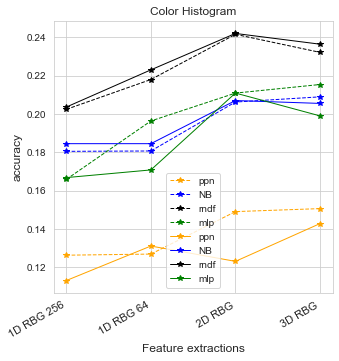

In [14]:
def calc_score_MLP(mlp, X, Y, cv, epochs, batch_size):
    kfold = KFold(n_splits=cv, shuffle=True)
    acc_per_fold = []
    for train, test in kfold.split(X, Y):
        train_data = np.take(X, train, 0)
        train_target = np.take(Y, train, 0)
        test_data = np.take(X, test, 0)
        test_target = np.take(Y, test, 0)
        history = mlp.fit(train_data, np_utils.to_categorical(train_target), batch_size=batch_size, epochs=epochs, verbose=0)
        y_pred = mlp.predict(test_data)
        #print(y_pred)
        score = accuracy_score(y_pred, test_target)
        acc_per_fold.append(score)
    return np.array(acc_per_fold)

# Classification
import warnings
warnings.filterwarnings('ignore')

# these are our feature sets; we will use each of them individually to train classifiers
trainingSets = [np_data, np_dataOpenCV_1D, np_dataOpenCV_2D, np_dataOpenCV_3D]
vals      = trainingSets
TestSets = [np_data_test, np_dataOpenCV_1D_test, np_dataOpenCV_2D_test, np_dataOpenCV_3D_test]
vals_test      = TestSets
trainingLabel=y_train
scores_ppn, scores_NB, scores_rndf, scores_mlp = [], [], [], []
scores_ppn_test, scores_NB_test, scores_rndf_test, scores_mlp_test = [], [], [], []

for X, X_t in zip(vals, vals_test):
    
    ppn = create_perceptron(pd.DataFrame(X), pd.DataFrame(trainingLabel))
    scores_ppn.append(cross_val_score(ppn, pd.DataFrame(X), pd.DataFrame(trainingLabel), scoring="accuracy", cv=10).mean())
    scores_ppn_test.append(accuracy_score(y_test, ppn.predict(X_t),normalize=True))

    
    NB = create_nb(pd.DataFrame(X), pd.DataFrame(trainingLabel))
    scores_NB.append(cross_val_score(NB, pd.DataFrame(X), pd.DataFrame(trainingLabel), scoring="accuracy", cv=10).mean())
    scores_NB_test.append(accuracy_score(y_test, NB.predict(X_t),normalize=True))
    
    rndf = create_rnd_forrest(pd.DataFrame(X), pd.DataFrame(trainingLabel),random_state=42, n_estimators=50)
    scores_rndf.append(cross_val_score(rndf, pd.DataFrame(X), pd.DataFrame(trainingLabel), scoring="accuracy", cv=10).mean())
    scores_rndf_test.append(accuracy_score(y_test, rndf.predict(X_t),normalize=True))
    
    create_scaling(X)
    X = scaler.transform(X)
    
    mlp = create_MLP(X, trainingLabel)
    scores_mlp.append(calc_score_MLP(mlp, X, trainingLabel, cv=10, epochs=15, batch_size=32).mean())
    scores_mlp_test.append(accuracy_score(y_test, mlp.predict(X_t),normalize=True))
        
print(scores_ppn)
print(scores_NB)
print(scores_rndf)
print(scores_mlp)
print(scores_ppn_test)

Nr_data = np.arange(4)
plt.figure(figsize=(5,5))
plt.plot(Nr_data, scores_ppn,"--",color="orange",marker="*", linewidth=1,label="ppn")
plt.plot(Nr_data, scores_NB,"--",color="blue",marker="*", linewidth=1,label="NB")
plt.plot(Nr_data, scores_rndf,"--",color="black",marker="*", linewidth=1,label="rndf")
plt.plot(Nr_data, scores_mlp,"--",color="green",marker="*", linewidth=1,label="mlp")
plt.plot(Nr_data, scores_ppn_test,"-",color="orange",marker="*", linewidth=1,label="ppn")
plt.plot(Nr_data, scores_NB_test,"-",color="blue",marker="*", linewidth=1,label="NB")
plt.plot(Nr_data, scores_rndf_test,"-",color="black",marker="*", linewidth=1,label="rndf")
plt.plot(Nr_data, scores_mlp_test,"-",color="green",marker="*", linewidth=1,label="mlp")
plt.legend(loc="best")
plt.title("Color Histogram",fontsize=12)
plt.ylabel("accuracy",fontsize=12)
plt.xlabel("Feature extractions",fontsize=12)
labels =["1D RBG 256", "1D RBG 64", "2D RBG", "3D RBG"]
plt.xticks(Nr_data, labels,rotation=30,fontsize=11, ha="right")
plt.savefig("./Accuracy_color_hist.pdf")

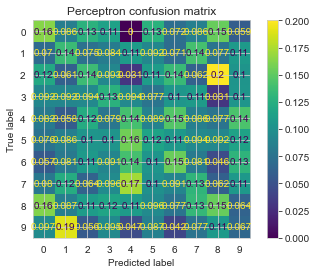

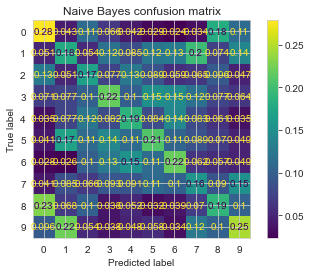

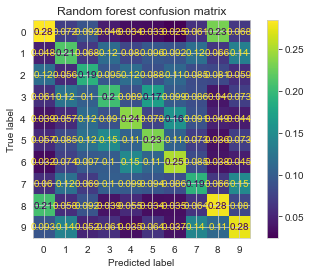

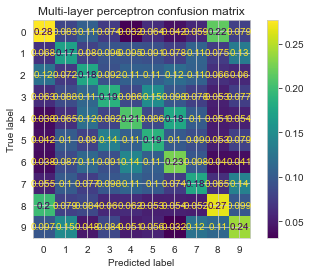

<Figure size 432x288 with 0 Axes>

In [15]:
#X_train, X_test, y_train, y_test = train_test_split(np_dataOpenCV_3D, trainingLabel, test_size=0.2, random_state=42)
X_train = np_dataOpenCV_2D
X_test = np_dataOpenCV_2D_test

times['histo ppn'] = time()
ppn = create_perceptron(X_train, y_train)
times['histo ppn'] = time() - times['histo ppn']
plot_confusion_matrix(ppn, X_test, y_test, normalize='pred')
plt.title('Perceptron confusion matrix')
plt.savefig("./CM__ppn_color_hist.pdf")

times['histo nb'] = time()
NB = create_nb(X_train, y_train)
times['histo nb'] = time() - times['histo nb']
plot_confusion_matrix(NB, X_test, y_test, normalize='pred')
plt.title('Naive Bayes confusion matrix')
plt.savefig("./CM__NB_color_hist.pdf")

times['histo rndf'] = time()
rndf = create_rnd_forrest(X_train, y_train, random_state=42, n_estimators=50)
times['histo rndf'] = time() - times['histo rndf']
plot_confusion_matrix(rndf, X_test, y_test, normalize='pred')
plt.title('Random forest confusion matrix')
plt.savefig("./CM__Rndf_color_hist.pdf")

times_prepro['scaling'] = time()
create_scaling(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)
times_prepro['scaling'] = time() - times_prepro['scaling']

times['histo mlp'] = time()
mlp = create_MLP(X_train, y_train)
times['histo mlp'] = time() - times['histo mlp']
plot_confusion_matrix_MLP(mlp, X_test, y_test)
plt.savefig("./CM__MLP_color_hist.pdf")

# SIFT

In [16]:
(X_train,y_train) , (X_test,y_test) = cifar10.load_data()
Image_grey=cv2.cvtColor(X_train[0], cv2.COLOR_BGR2GRAY)
X_train = X_train
y_train = y_train
X_test = X_test
y_test = y_test
print(X_train[0])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


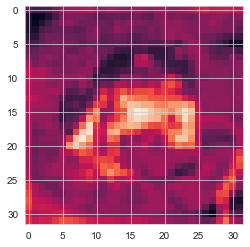

In [17]:
plt.imshow(Image_grey)

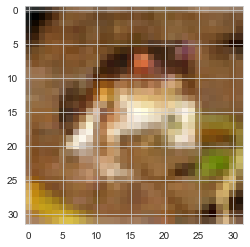

In [18]:
plt.imshow(X_train[0])

In [22]:
# SIFT
sift=cv2.xfeatures2d.SIFT_create()

# example of descriptors
keypoints, descriptors = sift.detectAndCompute(X_train[0], None)
keypoints, descriptors.astype('float64')

([<KeyPoint 0000020E5DDD9570>,
  <KeyPoint 0000020E5DEACB10>,
  <KeyPoint 0000020E5DEACAB0>,
  <KeyPoint 0000020E5E47F660>,
  <KeyPoint 0000020E5E4D6DB0>,
  <KeyPoint 0000020E5E4D6DE0>,
  <KeyPoint 0000020E5E4D6870>,
  <KeyPoint 0000020E5E4D6C00>,
  <KeyPoint 0000020E5E078B10>,
  <KeyPoint 0000020DEBB5D690>,
  <KeyPoint 0000020E5D595150>,
  <KeyPoint 0000020E5DE2FF00>,
  <KeyPoint 0000020E5DE2F6F0>,
  <KeyPoint 0000020E5E15E510>,
  <KeyPoint 0000020E5E15EC30>,
  <KeyPoint 0000020E5D6B57E0>,
  <KeyPoint 0000020E5D8FE2D0>,
  <KeyPoint 0000020E5E1A0D50>],
 array([[ 0.,  0.,  0., ..., 33., 33.,  1.],
        [ 3.,  0.,  0., ...,  0.,  0.,  0.],
        [19., 10.,  5., ...,  0.,  9., 10.],
        ...,
        [ 8.,  8.,  1., ...,  4.,  6.,  7.],
        [39., 68.,  9., ..., 96., 15.,  0.],
        [12.,  0.,  0., ...,  0.,  0.,  0.]]))

In [23]:
# resize X_train
X, Y = [], []

times_prepro['sift+bow'] = time()
# extract descriptors
descriptor_list = []
for i in range(len(X_train)):
    keypoints, descriptors = sift.detectAndCompute(X_train[i], None)
    if descriptors is None:
        plt.imshow(X_train[i])
    else:
        descriptor_list.append(descriptors)
        X.append(X_train[i])
        Y.append(y_train[i])

X_train = np.array(X)
y_train = np.array(Y)
input_size = len(X_train)

In [24]:
descriptor_vstack = np.array(descriptor_list[0])
for remaining in descriptor_list[1:]:
    descriptor_vstack = np.vstack((descriptor_vstack, remaining))
descriptor_vstack

array([[ 0.,  0.,  0., ..., 33., 33.,  1.],
       [ 3.,  0.,  0., ...,  0.,  0.,  0.],
       [19., 10.,  5., ...,  0.,  9., 10.],
       ...,
       [ 1.,  1.,  1., ...,  0.,  0., 61.],
       [ 3., 37., 58., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 28.,  0.,  0.]], dtype=float32)

In [25]:
# create clusters
n_clusters = 20
kmeans = KMeans(n_clusters = n_clusters)
kmeans = kmeans.fit_predict(descriptor_vstack)

In [26]:
print(kmeans)

[18 10 18 ...  1  2 13]


In [27]:
# create mega histogram
mega_histogram = np.array([np.zeros(n_clusters) for i in range(input_size)])
old_count = 0
for i in range(input_size): 
    l = len(descriptor_list[i])
    for j in range(l):
        idx = kmeans[old_count+j]
        mega_histogram[i][idx] += 1
    old_count += l
print("Vocabulary Histogram Generated")
mega_histogram

Vocabulary Histogram Generated


array([[0., 1., 0., ..., 0., 9., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 3., 0.],
       ...,
       [0., 2., 2., ..., 2., 2., 0.],
       [3., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 1.]])

In [28]:
# standardize
scale = StandardScaler().fit(mega_histogram)
X = scale.transform(mega_histogram)
times_prepro['sift+bow'] = time() - times_prepro['sift+bow']
X

array([[-0.70781251,  0.30354623, -0.74195002, ..., -0.67017537,
         7.83959979, -0.61099887],
       [ 0.41575373,  0.30354623, -0.74195002, ...,  0.59940029,
        -0.70231713, -0.61099887],
       [-0.70781251,  0.30354623,  0.31494702, ..., -0.67017537,
         2.14498851, -0.61099887],
       ...,
       [-0.70781251,  1.26570142,  1.37184406, ...,  1.86897596,
         1.19588663, -0.61099887],
       [ 2.66288621, -0.65860895, -0.74195002, ..., -0.67017537,
        -0.70231713,  0.72218672],
       [-0.70781251,  0.30354623,  0.31494702, ..., -0.67017537,
        -0.70231713,  0.72218672]])

0.14069019224584214
0.2063362670040542
0.20509373786643614
0.21783855830274054


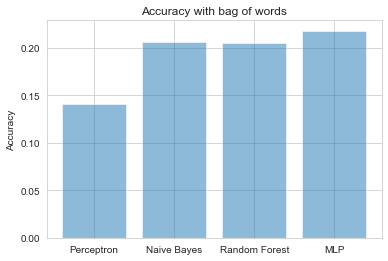

In [29]:
# Classification

trainingLabel=y_train[:input_size]

times['bow ppn'] = time()
ppn = create_perceptron(pd.DataFrame(X), pd.DataFrame(trainingLabel))
times['bow ppn'] = time() - times['bow ppn']
score_ppn = cross_val_score(ppn, pd.DataFrame(X), pd.DataFrame(trainingLabel), scoring="accuracy", cv=10).mean()

times['bow nb'] = time()
NB = create_nb(pd.DataFrame(mega_histogram), pd.DataFrame(trainingLabel)) # cannot take negative values
times['bow nb'] = time() - times['bow nb']
score_NB = cross_val_score(NB, pd.DataFrame(mega_histogram), pd.DataFrame(trainingLabel), scoring="accuracy", cv=10).mean()

times['bow rndf'] = time()
rndf = create_rnd_forrest(pd.DataFrame(X), pd.DataFrame(trainingLabel),random_state=42, n_estimators=50)
times['bow rndf'] = time() - times['bow rndf']
score_rndf = cross_val_score(rndf, pd.DataFrame(X), pd.DataFrame(trainingLabel), scoring="accuracy", cv=10).mean()

times['bow mlp'] = time()
mlp = create_MLP(X, trainingLabel)
times['bow mlp'] = time() - times['bow mlp']
score_mlp = calc_score_MLP(mlp, X, trainingLabel, cv=10, epochs=15, batch_size=32).mean()
    
print(score_ppn)
print(score_NB)
print(score_rndf)
print(score_mlp)


objects = ('Perceptron', 'Naive Bayes', 'Random Forest', 'MLP')
y_pos = np.arange(len(objects))
scores = [score_ppn, score_NB, score_rndf, score_mlp]

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Accuracy with bag of words')

plt.savefig("./Accuracy_BOW.pdf")
plt.show()

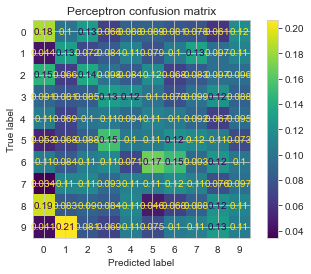

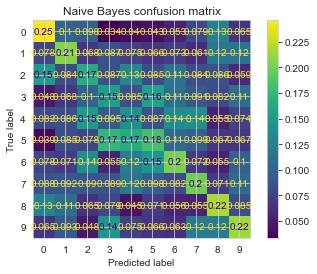

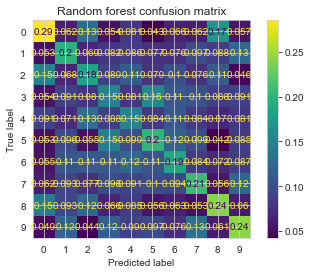

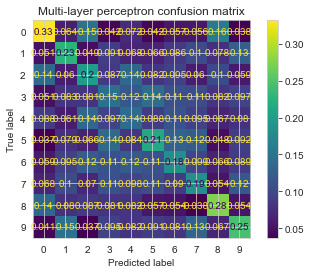

<Figure size 432x288 with 0 Axes>

In [30]:
_X_train, _X_test, y_train, y_test = train_test_split(mega_histogram, trainingLabel, test_size=0.2, random_state=42)
X_train, X_test = scale.transform(_X_train), scale.transform(_X_test)

ppn = create_perceptron(X_train, y_train)
plot_confusion_matrix(ppn, X_test, y_test, normalize='pred')
plt.title('Perceptron confusion matrix')
plt.savefig("./CM__ppn_BOW.pdf")

NB = create_nb(_X_train, y_train)
plot_confusion_matrix(NB, _X_test, y_test, normalize='pred')
plt.title('Naive Bayes confusion matrix')
plt.savefig("./CM__NB_BOW.pdf")

rndf = create_rnd_forrest(X_train, y_train, random_state=42, n_estimators=50)
plot_confusion_matrix(rndf, X_test, y_test, normalize='pred')
plt.title('Random forest confusion matrix')
plt.savefig("./CM__Rndf_BOW.pdf")

mlp = create_MLP(X_train, y_train)
plot_confusion_matrix_MLP(mlp, X_test, y_test)
plt.savefig("./CM__MLP_BOW.pdf")

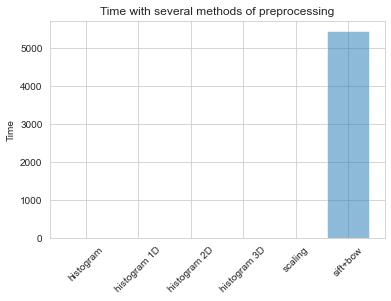

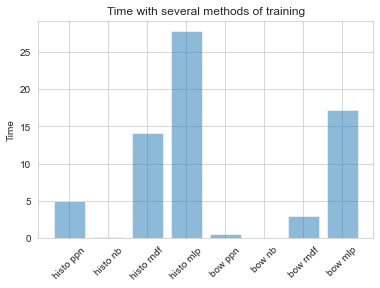

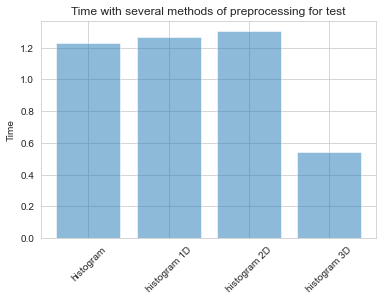

In [31]:
objects = times_prepro.keys()
y_pos = np.arange(len(objects))
scores = times_prepro.values()

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('Time')
plt.title('Time with several methods of preprocessing')

plt.savefig("./time_prepro.pdf")
plt.show()

objects = times.keys()
y_pos = np.arange(len(objects))
scores = times.values()

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('Time')
plt.title('Time with several methods of training')

plt.savefig("./time_training.pdf")
plt.show()

objects = times_test.keys()
y_pos = np.arange(len(objects))
scores = times_test.values()

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('Time')
plt.title('Time with several methods of preprocessing for test')

plt.savefig("./time_training_test.pdf")
plt.show()